# Lab 9 - projekt 4

In [1]:
import torch
import numpy as np
import torch.nn as nn

In [2]:
device = torch.device('cuda') # torch.device('cpu')
device

device(type='cuda')

In [3]:
if torch.cuda.is_available(): 
    torch.cuda.manual_seed(452)
    torch.cuda.manual_seed_all(452)
    
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(132)
np.random.seed(31445)

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import pickle
data = pickle.load( open( "gdrive/MyDrive/SSNE/proj4/train.pkl", "rb" ) )
data = np.array(data)

<ipython-input-5-44beaadec602>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)


In [6]:
unique, counts = np.unique(np.array(data, dtype=tuple)[:,1], return_counts=True)
print(unique, counts)

[0 1 2 3 4] [1630  478  154  441  236]


In [7]:
inputs = []
for input, _ in data:
  inputs.append(torch.from_numpy(input).float())
targets = torch.from_numpy(data[:,1].astype(float)).float()

In [8]:
from torch.utils.data import Dataset

class VariableLenDataset(Dataset):
    def __init__(self, in_data, target):
        self.data = [(x, y) for x, y in zip(in_data, target)]      

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        in_data, target = self.data[idx]
        return in_data, target

In [9]:
whole_set = VariableLenDataset(inputs, targets)

In [10]:
from torch.utils.data import random_split
train_set_size = int(len(data) * 0.8)
valid_set_size = len(data) - train_set_size
train_set, valid_set = random_split(whole_set, [train_set_size, valid_set_size])
print(len(train_set))

2351


In [11]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

def pad_collate(batch, pad_value=0):
    batch.sort(key=lambda t: len(t[0]), reverse=True)
    xx, yy = zip(*batch)
    x_lens = [len(x) for x in xx]
    y_lens = [1 for y in yy]

    xx_pad = pad_sequence(xx, batch_first=True, padding_value=pad_value)

    return xx_pad, torch.stack((yy)), x_lens, y_lens

In [12]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, collate_fn=pad_collate)
valid_loader = DataLoader(valid_set, batch_size=64, shuffle=False, drop_last=False, collate_fn=pad_collate)

In [13]:
class LSTM_Seq_Regressor(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, out_size):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.proj_size = out_size
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, proj_size = out_size, dropout=0.5)
        
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.proj_size)
        state = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return hidden, state
    
    def forward(self, x, hidden):
        all_outputs, hidden = self.lstm(x, hidden)
        return all_outputs, hidden
    
model = LSTM_Seq_Regressor(1, 200, 1, 5).to(device)
model

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


LSTM_Seq_Regressor(
  (lstm): LSTM(1, 200, proj_size=5, dropout=0.5)
)

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fun = nn.CrossEntropyLoss()

In [15]:
def getLastSeqItems(packed, sorted_lengths): # mine
    sum_batch_sizes = torch.cat((
        torch.zeros(2, dtype=torch.int64),
        torch.cumsum(packed.batch_sizes, 0)
    ))
    last_seq_idxs = sum_batch_sizes[sorted_lengths] + torch.arange(len(sorted_lengths))
    last_seq_items = packed.data[last_seq_idxs]
    return last_seq_items

In [16]:
# Training loop
epoch_iter = []
loss_loss = []
i = 1
for epoch in range(160):
    for x, targets, x_len, target_len in train_loader:
        x = x.to(device).unsqueeze(2)

        targets = targets.type(torch.LongTensor).to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device) 
        
        x_packed = pack_padded_sequence(x, x_len, batch_first=True)
        preds_packed, preds_packed_len = model(x_packed, (hidden, state))
        preds = getLastSeqItems(preds_packed, x_len).squeeze(0)

        optimizer.zero_grad()
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
    epoch_iter.append(i)
    loss_loss.append(loss.item())
    i += 1
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 1.21
Epoch: 10, loss: 1.12
Epoch: 20, loss: 0.889
Epoch: 30, loss: 0.721
Epoch: 40, loss: 0.599
Epoch: 50, loss: 0.881
Epoch: 60, loss: 0.68
Epoch: 70, loss: 0.5
Epoch: 80, loss: 0.729
Epoch: 90, loss: 0.854
Epoch: 100, loss: 0.531
Epoch: 110, loss: 0.534
Epoch: 120, loss: 0.688
Epoch: 130, loss: 0.675
Epoch: 140, loss: 0.509
Epoch: 150, loss: 0.553


<function matplotlib.pyplot.show(*args, **kw)>

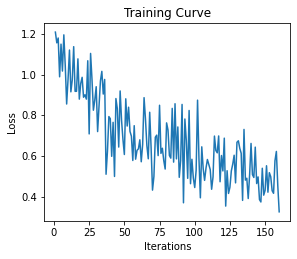

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
plt.subplot(2,3,1)
plt.title("Training Curve")
plt.plot(epoch_iter, loss_loss, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show

In [18]:
def get_accuracy(loader):
    model.eval()
    true_preds = 0
    all_preds = 0
    with torch.no_grad():
        for x, targets, x_len, target_len in loader:
            x = x.to(device).unsqueeze(2)
            targets = targets.to(device)
            hidden, state = model.init_hidden(x.shape[0])
            hidden, state = hidden.to(device), state.to(device)
            
            x_packed = pack_padded_sequence(x, x_len, batch_first=True)
            preds_packed, _ = model(x_packed, (hidden, state))
            preds = getLastSeqItems(preds_packed, x_len).squeeze(0)
            true_preds += (torch.argmax(preds,1)==targets).sum().item()
            all_preds += len(targets)
    return true_preds/all_preds


In [19]:
print(f"Train dataset accuraccy: {get_accuracy(train_loader)}")
print(f"Validation dataset accuracy: {get_accuracy(valid_loader)}")

Train dataset accuraccy: 0.8575074436410038
Validation dataset accuracy: 0.7517006802721088


# Test data classification

In [20]:
test_data = pickle.load( open( "gdrive/MyDrive/SSNE/proj4/test_no_target.pkl", "rb" ) )
test_data = np.array(test_data)

<ipython-input-20-17722c0f24fe>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_data = np.array(test_data)


In [27]:
test_data.size

1103

In [21]:
test_inputs = []
for input in test_data:
    test_inputs.append(torch.from_numpy(input).float())
test_inputs
zeros = []
for z in range(len(test_inputs)):
    zeros.append(torch.tensor(0,dtype=float))
test_targets = torch.from_numpy(np.asarray(zeros))

In [22]:
test_dataset = VariableLenDataset(test_inputs, test_targets)

In [23]:
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=False, collate_fn=pad_collate)

In [24]:
predictions = []
model.eval()
with torch.no_grad():
    for x, targets, x_len, target_len in test_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.shape[0])
        hidden, state = hidden.to(device), state.to(device)
        hidden, state = hidden.float(), state.float()

        x_packed = pack_padded_sequence(x, x_len, batch_first=True)
        preds_packed, _ = model(x_packed, (hidden, state))
        preds = getLastSeqItems(preds_packed, x_len).squeeze(0)

        predictions.append(torch.argmax(preds,1))

In [25]:
import csv
with open("/content/gdrive/MyDrive/SSNE/proj4/piatek_bielak_nitkiewicz.csv","w",newline='') as f:
    csv_writer = csv.writer(f, delimiter=",")
    for batch in predictions:
        for p in batch:
            csv_writer.writerow([p.data.item()])

In [26]:
torch.save(model.state_dict(), "/content/gdrive/MyDrive/SSNE/proj4/model_75_final")